In [365]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

In [366]:
# Função para codificar variáveis e padronizar dados
def preprocess_data(df, categorical_vars):
    y = df['HEART_ATTACK']
    X = df.drop(columns=['HEART_ATTACK'])
    
    # Codificar variáveis categóricas
    X_encoded = pd.get_dummies(X, columns=categorical_vars, drop_first=True)
    
    # Padronizar variáveis numéricas
    numerical_vars = X_encoded.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    X_encoded[numerical_vars] = scaler.fit_transform(X_encoded[numerical_vars])
    
    return X_encoded, y

# Função para criar gráfico de barras horizontais
def plot_top_features(coef_df, top_n=5):
    top_features = coef_df.nlargest(top_n, 'Coefficient')
    
    plt.figure(figsize=(10, 8))
    plt.barh(top_features['Feature'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coeficiente', fontsize=14)
    plt.ylabel('Variável', fontsize=14)
    plt.title(f'Top {top_n} Variáveis com Maior Coeficiente', fontsize=16)
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Função para plotar curva ROC
def plot_roc_curve(model, X_test, y_test, model_name):
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
    else:
        raise ValueError(f"O modelo {model_name} não suporta previsão de probabilidade.")
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.fill_between(fpr, tpr, alpha=0.2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=14)
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=14)
    plt.title(f'Curva ROC - {model_name}', fontsize=16)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [367]:
df=pd.read_csv('dados_agregados_limpos.csv')

pd.set_option('display.max_rows', None)


#Limpando variáveis para utilizar os modelos de predição

df.drop(['SLEEP_TIME', 'Unnamed: 0'], axis=1, inplace=True)


vars_to_clean_1 = [
    'SMOKE', 'KIDNEY_DISEASE', 'DIALYSES', 'GENDER', 'RACE', 'EDUCATION', 
    'MARITAL_STATUS', 'HIGH_PRESSURE', 'HIGH_CHOLESTEROL', 
    'ASTHMA', 'BLOOD_TRANSFUSION', 'ARTHRITIS', 'CONGESTIVE_HEART_FAILURE', 
    'CORONARY_DISEASE', 'HEART_ATTACK', 'STROKE', 'THYROID_PROBLEMA', 
    'COPD', 'LIVER_DISEASE', 'ABDOMINAL_PAIN', 'GALLSTONES', 'CANCER', 
    'HEALTH_INSURANCE', 'SNORE', 'SNORT', 'TROUBLE_SLEEPING', 'OVERLY_SLEEPY'
]

# Lista das variáveis para a segunda limpeza (remover 77, 99)
vars_to_clean_2 = ['ALCOHOL_FREQUENCY', 'VIGOROUS_ACTIVITY', 'MODERATE_ACTIVITY']

# Remover linhas com valores 9, 7, 77 nas primeiras variáveis
df = df[~df[vars_to_clean_1].isin([9, 7, 77]).any(axis=1)]

# Remover linhas com valores 77, 99 nas segundas variáveis
df = df[~df[vars_to_clean_2].isin([77, 99]).any(axis=1)]

#Deixando as variáveis alvo com respostas binárias para a ocorrência ou não do evento
targets = ['DIABETES', 'STROKE', 'HEART_ATTACK', 'HIGH_PRESSURE', 'HIGH_CHOLESTEROL']

df[targets] = df[targets].applymap(lambda x: 1 if x == 1 else 0)

Treinando Logistic Regression...
Acurácia do Logistic Regression: 0.96


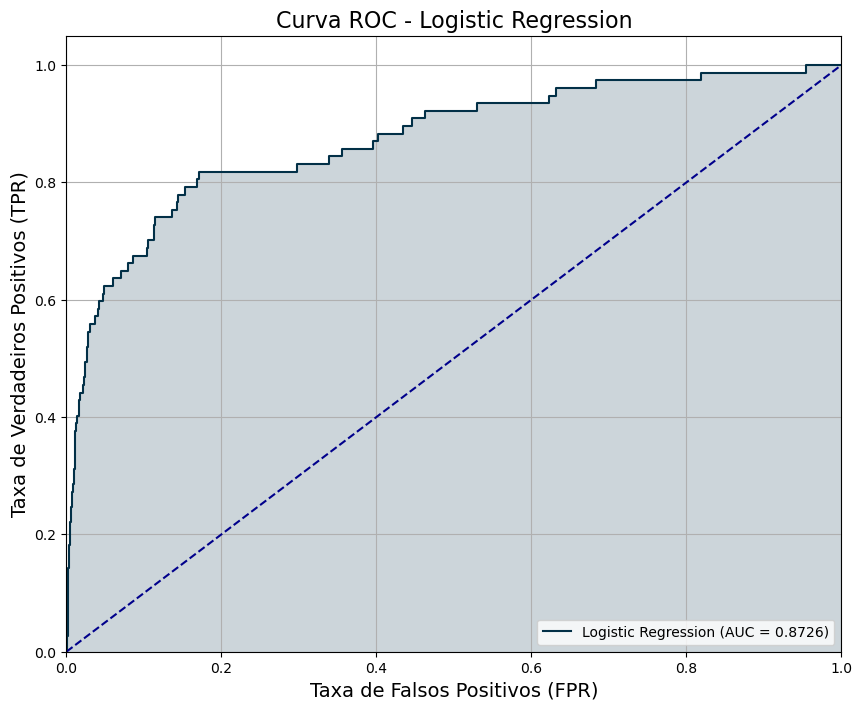

Treinando Decision Tree...
Acurácia do Decision Tree: 0.94


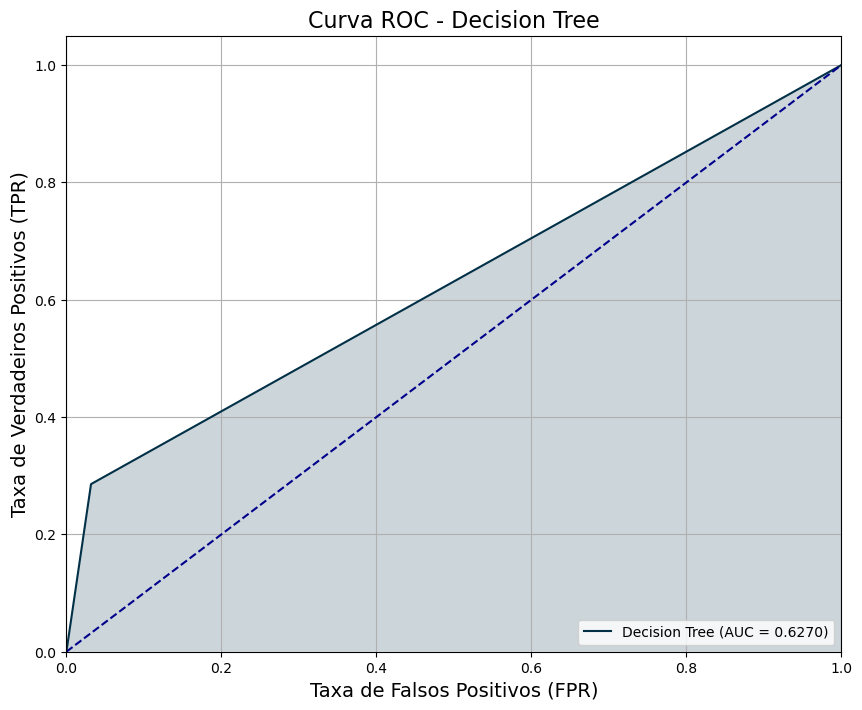

Treinando Random Forest...
Acurácia do Random Forest: 0.96


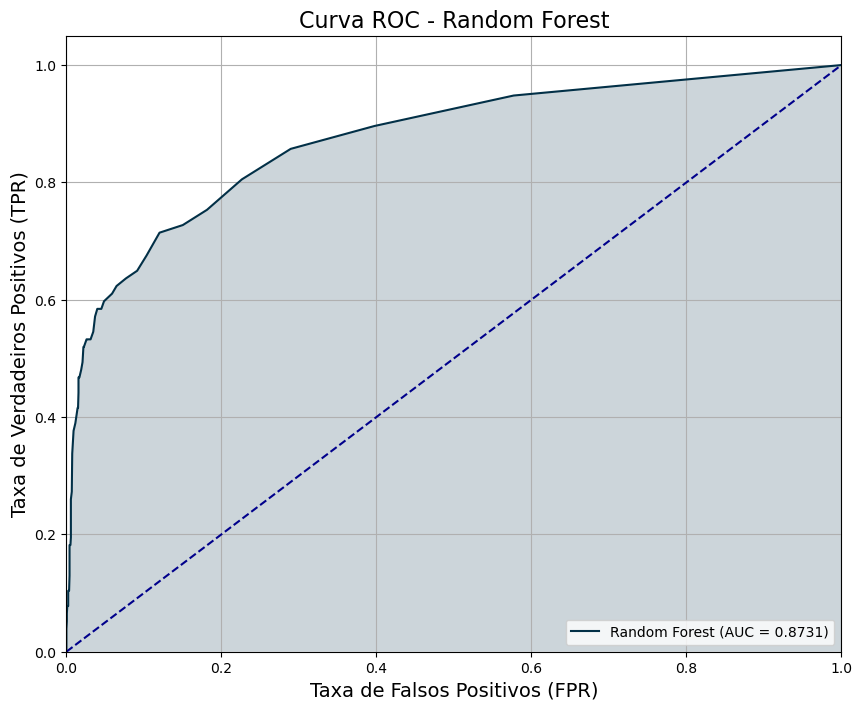

Treinando SVM...
Acurácia do SVM: 0.96


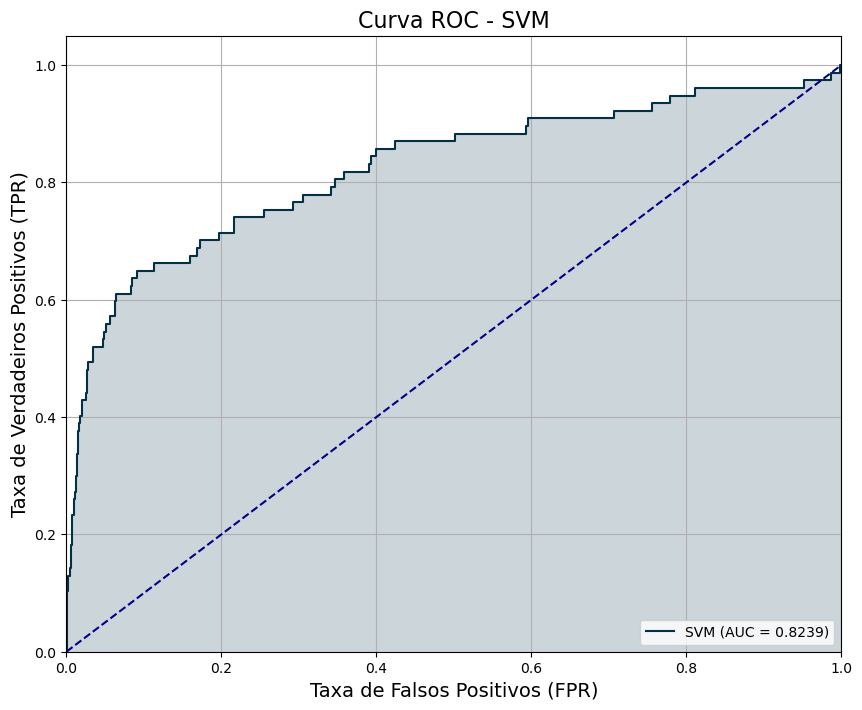

Treinando XGBoost...
Acurácia do XGBoost: 0.96


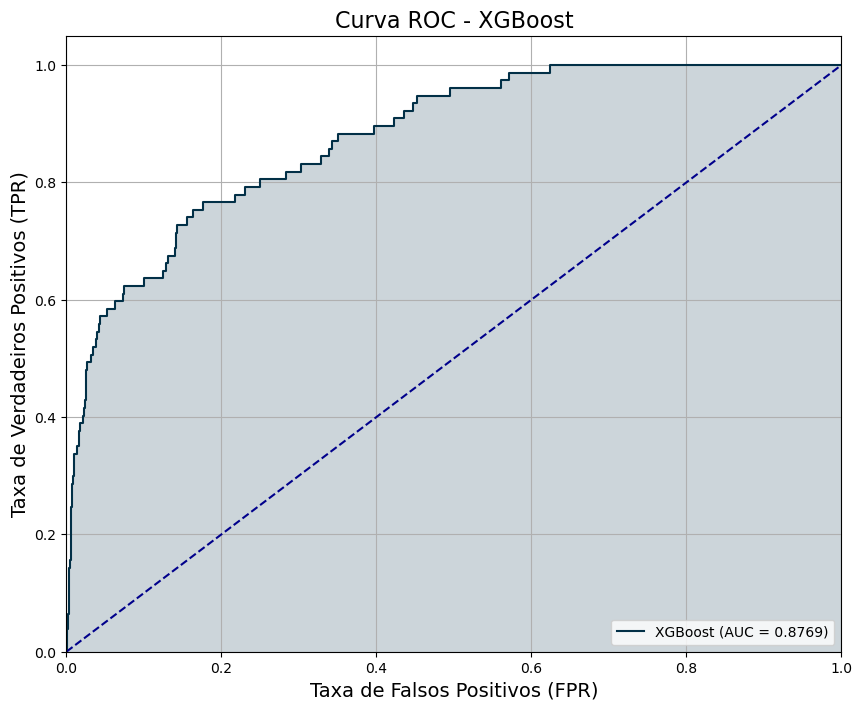

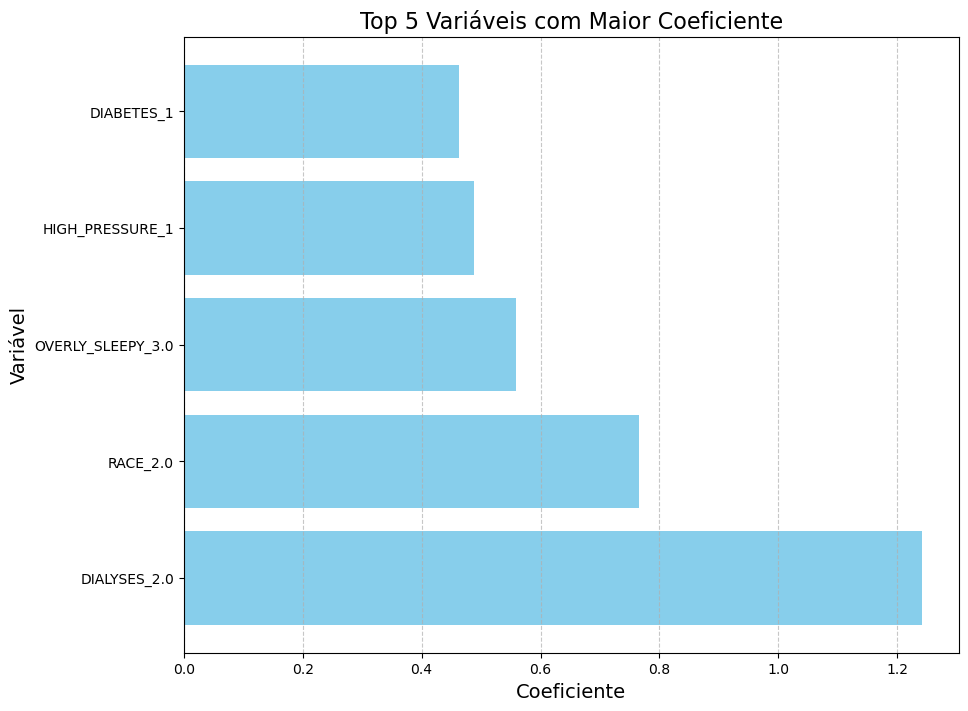

In [368]:
# Definir variáveis categóricas
categorical_vars = [
    'ALCOHOL_FREQUENCY', 'VIGOROUS_ACTIVITY', 'MODERATE_ACTIVITY', 'SMOKE', 
    'KIDNEY_DISEASE', 'DIALYSES', 'GENDER', 'RACE', 'EDUCATION', 
    'MARITAL_STATUS', 'STROKE', 'HIGH_PRESSURE', 
    'ASTHMA', 'BLOOD_TRANSFUSION', 'ARTHRITIS', 'CONGESTIVE_HEART_FAILURE', 
    'CORONARY_DISEASE', 'HIGH_CHOLESTEROL', 'DIABETES', 'THYROID_PROBLEMA', 
    'COPD', 'LIVER_DISEASE', 'ABDOMINAL_PAIN', 'GALLSTONES', 'CANCER', 
    'HEALTH_INSURANCE', 'SNORE', 'SNORT', 'TROUBLE_SLEEPING', 'OVERLY_SLEEPY'
]

# Processar dados
X_encoded, y = preprocess_data(df, categorical_vars)

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Modelos a serem testados
models = {
    'Logistic Regression': LogisticRegression(random_state=68, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=68),
    'Random Forest': RandomForestClassifier(random_state=68),
    'SVM': SVC(probability=True, random_state=68),  # SVM precisa de probability=True para usar predict_proba
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
}

# Treinar, prever e avaliar modelos
for model_name, model in models.items():
    print(f"Treinando {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Acurácia do {model_name}: {accuracy:.2f}")
    
    # Plotar curva ROC
    plot_roc_curve(model, X_test, y_test, model_name)

# Extração dos coeficientes do modelo de Regressão Logística
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
coefficients = log_reg.coef_[0]
features = X_encoded.columns

# Criar DataFrame com variáveis e coeficientes
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

# Plotar as 5 variáveis com maior coeficiente
plot_top_features(coef_df, top_n=5)

In [372]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, recall_score, accuracy_score, precision_recall_curve, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Repetindo o modelo Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Prever os resultados no conjunto de teste
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calcular as métricas de desempenho
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Exibir os resultados
print(f"Acurácia do modelo: {accuracy:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"Recall: {recall:.2f}")

# Criar e exibir a matriz de confusão
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

# Exibir o relatório de classificação
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

# Obter a importância das variáveis
importances = model.feature_importances_
features = X_encoded.columns

# Criar um DataFrame para visualizar a importância das variáveis
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


Acurácia do modelo: 0.96
ROC AUC: 0.89
F1-score: 0.18
Recall: 0.10
Confusion Matrix:
 [[1727    4]
 [  69    8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1731
           1       0.67      0.10      0.18        77

    accuracy                           0.96      1808
   macro avg       0.81      0.55      0.58      1808
weighted avg       0.95      0.96      0.95      1808



In [375]:
X_train = X_train.astype(int)


In [381]:
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE no conjunto de treino
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Treinar o modelo com dados balanceados
model = RandomForestClassifier(random_state=42)
model.fit(X_train_sm, y_train_sm)

# Prever os resultados no conjunto de teste
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Avaliar o modelo
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred_prob))
print(f'F1-score: {f1_score(y_test, y_pred):.2f}')
print(f'Recall: {recall_score(y_test, y_pred):.2f}')

Confusion Matrix:
 [[1721   10]
 [  64   13]]
ROC AUC: 0.8770547765348458
F1-score: 0.26
Recall: 0.17
